<a href="https://colab.research.google.com/github/risyadksm/PATTERN-RECOGNITION-2025/blob/main/rev_RISYAD_PATTERN_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MUH. NUR RISYAD RAIS RAFSANJANI HADI KUSUMA (245107080001)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, random
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image, ImageEnhance, ImageFilter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes, disk, binary_opening, binary_closing
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import regionprops
from scipy import ndimage as ndi
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path

BASE_DIR = Path("/content/drive/MyDrive/UASSOYBEAN")

DATASETS = [
    {"name": "GOOD",        "dir": BASE_DIR/"GOOD"},
    {"name": "BROKEN",      "dir": BASE_DIR/"BROKEN"},
    {"name": "SPOTTED",     "dir": BASE_DIR/"SPOTTED"},
    {"name": "SKIN-DAMAGE", "dir": BASE_DIR/"SKIN-DAMAGE"},
    {"name": "WRINKLED",    "dir": BASE_DIR/"WRINKLED"},
]

exts = ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG")

for d in DATASETS:
    files = []
    for e in exts:
        files += list(d["dir"].glob(e))

    d["inp_list"] = sorted(files)
    d["out_seg"] = d["dir"]
    d["out_aug"] = d["dir"]

    print(d["name"], "images:", len(d["inp_list"]))

GOOD images: 1
BROKEN images: 2
SPOTTED images: 1
SKIN-DAMAGE images: 1
WRINKLED images: 1


# **PRE-PROCESSING**
#### SEGMENTATION

In [ ]:
pad = 12
min_area = 1500
min_dist = 25 # naikkan kalau biji masih gabung (30-40)
peak_thr = 8 # turunkan kalau biji kecil tidak kepisah (6-8)

for d in DATASETS:
    src = []
    for p in d["inp_list"]:
        n = p.name.lower()
        is_seg = re.match(r"^s\d{3}_\d{4}\.jpg$", n) is not None
        is_aug = re.search(r"_a\d{2}\.jpg$", n) is not None
        if not (is_seg or is_aug):
            src.append(p)

    total = 0
    for i, p in enumerate(src, start=1):
        img = np.array(Image.open(p).convert("RGB"))
        g = rgb2gray(img)

        m = g > threshold_otsu(g)
        m = remove_small_objects(m, 800)
        m = remove_small_holes(m, 800)
        m = binary_opening(m, disk(3))
        m = binary_closing(m, disk(7))
        m = remove_small_objects(m, min_area)

        dist = ndi.distance_transform_edt(m)
        peaks = peak_local_max(dist, labels=m, min_distance=min_dist, threshold_abs=peak_thr)

        if len(peaks) == 0:
            labels_ws = (m > 0).astype(np.int32)
        else:
            markers = np.zeros_like(dist, dtype=np.int32)
            markers[peaks[:, 0], peaks[:, 1]] = np.arange(1, len(peaks) + 1)
            labels_ws = watershed(-dist, markers, mask=m)

        H, W = m.shape
        for r in regionprops(labels_ws):
            if r.area < min_area:
                continue

            total += 1
            minr, minc, maxr, maxc = r.bbox
            minr = max(0, minr - pad); minc = max(0, minc - pad)
            maxr = min(H, maxr + pad); maxc = min(W, maxc + pad)

            crop = img[minr:maxr, minc:maxc]
            mm = (labels_ws[minr:maxr, minc:maxc] == r.label)

            out = np.zeros_like(crop)  # bg hitam
            out[mm] = crop[mm]

            Image.fromarray(out, "RGB").save(d["out_seg"] / f"s{i:03d}_{total:04d}.jpg", quality=95)

    print(d["name"], "=>", total, "seed")

/tmp/ipython-input-3850328806.py:53: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(out, "RGB").save(d["out_seg"] / f"s{i:03d}_{total:04d}.jpg", quality=95)


GOOD => 88 seed
BROKEN => 83 seed
SPOTTED => 73 seed
SKIN-DAMAGE => 86 seed
WRINKLED => 67 seed


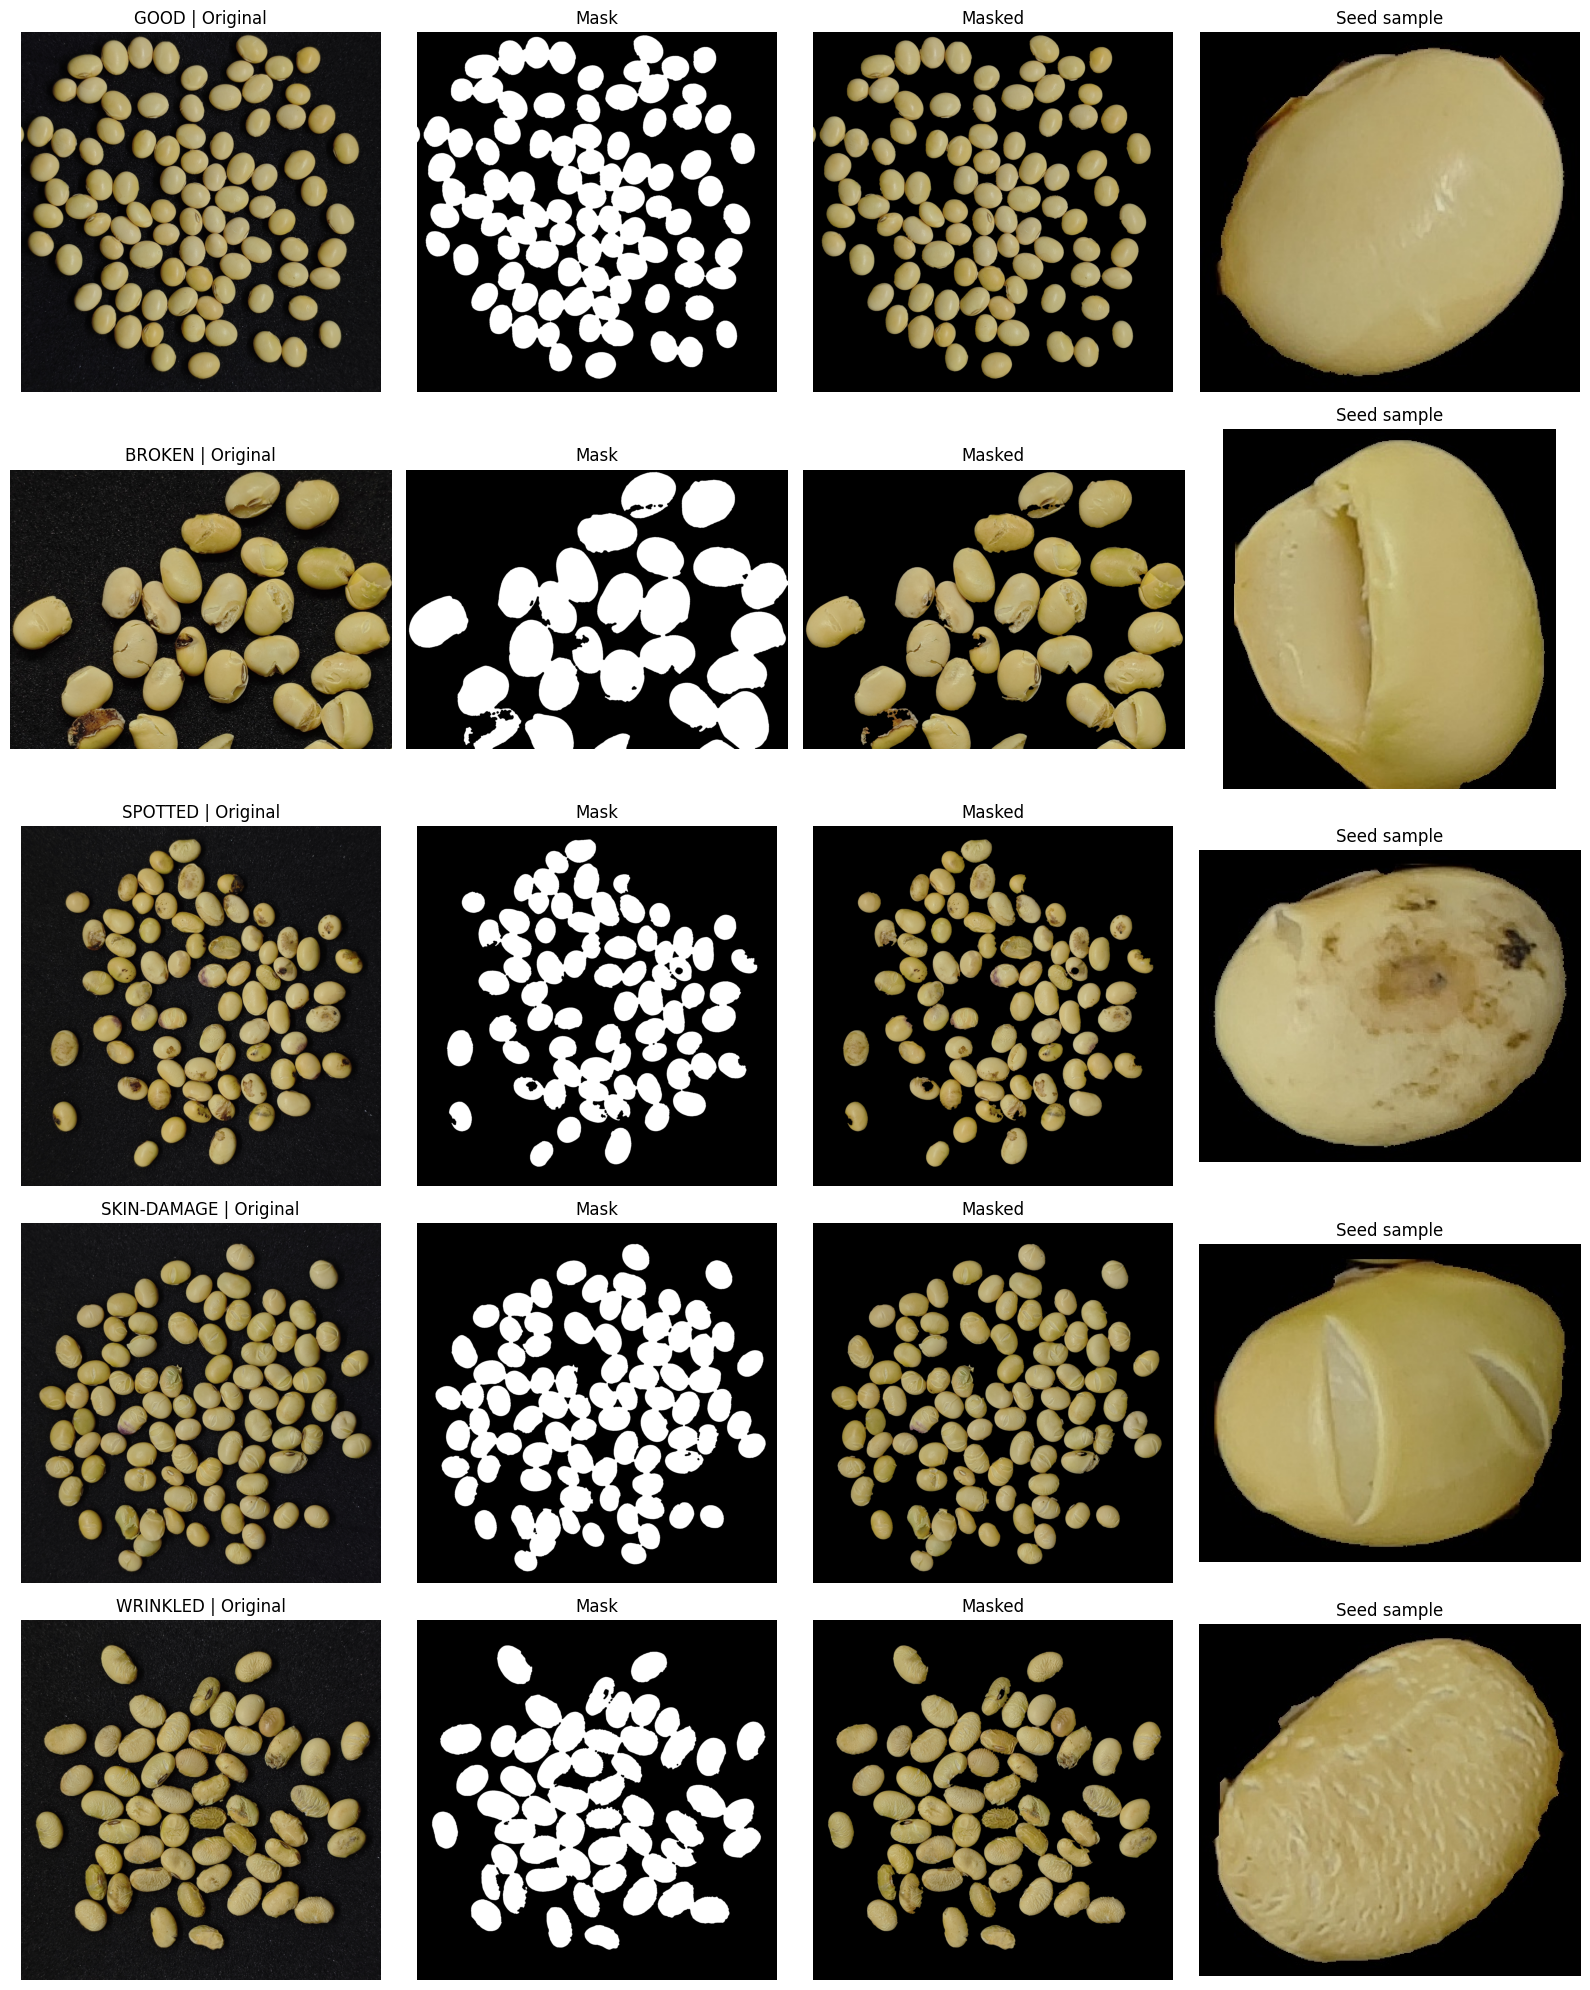

In [ ]:
rows = len(DATASETS)
fig, ax = plt.subplots(rows, 4, figsize=(16, 4*rows))

for i, d in enumerate(DATASETS):
    src = []
    for p in d["inp_list"]:
        n = p.name.lower()
        is_seg = re.match(r"^s\d{3}_\d{4}\.jpg$", n) is not None
        is_aug = re.search(r"_a\d{2}\.jpg$", n) is not None
        if not (is_seg or is_aug):
            src.append(p)

    if len(src) == 0:
        ax[i,0].set_title(f"{d['name']} - No source image")
        for j in range(4): ax[i,j].axis("off")
        continue

    p = src[0]
    img = np.array(Image.open(p).convert("RGB"))
    g = rgb2gray(img)

    m = g > threshold_otsu(g)
    m = remove_small_objects(m, 800)
    m = remove_small_holes(m, 800)
    m = binary_opening(m, disk(3))
    m = binary_closing(m, disk(7))

    masked = img.copy()
    masked[~m] = 0

    ax[i,0].imshow(img); ax[i,0].set_title(f"{d['name']} | Original"); ax[i,0].axis("off")
    ax[i,1].imshow(m, cmap="gray"); ax[i,1].set_title("Mask"); ax[i,1].axis("off")
    ax[i,2].imshow(masked); ax[i,2].set_title("Masked"); ax[i,2].axis("off")

    # segmentation result
    seg_files = sorted([q for q in d["dir"].glob("s*.jpg") if re.match(r"^s\d{3}_\d{4}\.jpg$", q.name.lower())])
    if len(seg_files) == 0:
        ax[i,3].set_title("Seed: not found"); ax[i,3].axis("off")
    else:
        seed_img = np.array(Image.open(seg_files[0]).convert("RGB"))
        ax[i,3].imshow(seed_img); ax[i,3].set_title("Seed sample"); ax[i,3].axis("off")

plt.tight_layout();
plt.show()

# AUGMENTATION

In [ ]:
n_aug = 12
bg = (0, 0, 0)
overwrite = False

random.seed(42)
np.random.seed(42)

for d in DATASETS:
    seeds = sorted([p for p in d["dir"].glob("s*.jpg")
                    if re.match(r"^s\d{3}_\d{4}\.jpg$", p.name.lower())])

    total = 0
    for p in seeds:
        im0 = Image.open(p).convert("RGB")
        w, h = im0.size

        for j in range(1, n_aug + 1):
            out_path = d["dir"] / f"{p.stem}_a{j:02d}.jpg"
            if (not overwrite) and out_path.exists():
                continue

            angle = random.uniform(-25, 25)
            scale = random.uniform(0.85, 1.20)
            bright = random.uniform(0.75, 1.25)
            contrast = random.uniform(0.80, 1.25)
            color = random.uniform(0.85, 1.20)
            sharp = random.uniform(0.80, 1.20)
            hflip = random.random() < 0.5
            vflip = random.random() < 0.1
            blur_r = random.uniform(0.0, 1.2)
            noise_sigma = random.uniform(0.0, 8.0)

            im = im0.rotate(angle, resample=Image.Resampling.BICUBIC,
                            expand=False, fillcolor=bg)

            # zoom
            nw, nh = int(round(w * scale)), int(round(h * scale))
            rz = im.resize((max(1, nw), max(1, nh)), resample=Image.Resampling.BICUBIC)
            if scale >= 1.0:
                left = (rz.size[0] - w) // 2
                top = (rz.size[1] - h) // 2
                im = rz.crop((left, top, left + w, top + h))
            else:
                canvas = Image.new("RGB", (w, h), bg)
                left = (w - rz.size[0]) // 2
                top = (h - rz.size[1]) // 2
                canvas.paste(rz, (left, top))
                im = canvas

            if hflip:
                im = im.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
            if vflip:
                im = im.transpose(Image.Transpose.FLIP_TOP_BOTTOM)

            im = ImageEnhance.Brightness(im).enhance(bright)
            im = ImageEnhance.Contrast(im).enhance(contrast)
            im = ImageEnhance.Color(im).enhance(color)
            im = ImageEnhance.Sharpness(im).enhance(sharp)

            if blur_r > 0:
                im = im.filter(ImageFilter.GaussianBlur(radius=blur_r))

            if noise_sigma > 0:
                arr = np.array(im).astype(np.float32)
                arr += np.random.normal(0, noise_sigma, arr.shape).astype(np.float32)
                arr = np.clip(arr, 0, 255).astype(np.uint8)
                im = Image.fromarray(arr, "RGB")

            im.save(out_path, quality=95)
            total += 1

    print(d["name"], "=>", total, "aug")

/tmp/ipython-input-1425564751.py:67: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  im = Image.fromarray(arr, "RGB")


GOOD => 1044 aug
BROKEN => 996 aug
SPOTTED => 876 aug
SKIN-DAMAGE => 1032 aug
WRINKLED => 804 aug


# SPLIT DATASET

In [ ]:
BASE_DIR = Path("/content/drive/MyDrive/UASSOYBEAN")
CLASSES = ["GOOD", "BROKEN", "SPOTTED", "SKIN-DAMAGE", "WRINKLED"]

rows = []
for c in CLASSES:
    class_dir = BASE_DIR / c

    seg = [p for p in class_dir.glob("s*.jpg")
           if re.match(r"^s\d{3}_\d{4}\.jpg$", p.name.lower())]

    aug = [p for p in class_dir.glob("s*_a*.jpg")
           if re.match(r"^s\d{3}_\d{4}_a\d+\.jpg$", p.name.lower())]

    for p in (seg + aug):
        rows.append({"Filepath": str(p), "Label": c})

df = pd.DataFrame(rows)
print("Total images:", len(df))
print(df["Label"].value_counts())

train_df, temp_df = train_test_split(
    df, train_size=0.70, shuffle=True, random_state=42, stratify=df["Label"]
)
val_df, test_df = train_test_split(
    temp_df, train_size=0.50, shuffle=True, random_state=42, stratify=temp_df["Label"]
)

print(f"Training Data   : {len(train_df)} gambar")
print(f"Validation Data : {len(val_df)} gambar")
print(f"Test Data       : {len(test_df)} gambar")

Total images: 5148
Label
GOOD           1131
SKIN-DAMAGE    1118
BROKEN         1079
SPOTTED         949
WRINKLED        871
Name: count, dtype: int64
Training Data   : 3603 gambar
Validation Data : 772 gambar
Test Data       : 773 gambar


# DATA PREPARATION

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_gen.flow_from_dataframe(
    train_df, x_col="Filepath", y_col="Label",
    target_size=IMG_SIZE, color_mode="rgb",
    class_mode="categorical", batch_size=BATCH_SIZE,
    shuffle=True, seed=42
)

val_images = val_gen.flow_from_dataframe(
    val_df, x_col="Filepath", y_col="Label",
    target_size=IMG_SIZE, color_mode="rgb",
    class_mode="categorical", batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = test_gen.flow_from_dataframe(
    test_df, x_col="Filepath", y_col="Label",
    target_size=IMG_SIZE, color_mode="rgb",
    class_mode="categorical", batch_size=BATCH_SIZE,
    shuffle=False
)

print("Classes:", train_images.class_indices)
NUM_CLASSES = len(train_images.class_indices)

Found 3603 validated image filenames belonging to 5 classes.
Found 772 validated image filenames belonging to 5 classes.
Found 773 validated image filenames belonging to 5 classes.
Classes: {'BROKEN': 0, 'GOOD': 1, 'SKIN-DAMAGE': 2, 'SPOTTED': 3, 'WRINKLED': 4}


## FEATURE EXTRACTION

Ekstraksi fitur menggunakan MobileNetV2 pre-trained untuk mengekstrak representasi fitur dari gambar

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# Load MobileNetV2 pre-trained tanpa layer fully connected
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Model untuk ekstraksi fitur
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

print("Feature Extractor Model:")
print(f"Input shape: {feature_extractor.input_shape}")
print(f"Output shape: {feature_extractor.output_shape}")
print(f"Total features extracted: {feature_extractor.output_shape[-1]}")


Feature Extractor Model:
Input shape: (None, 224, 224, 3)
Output shape: (None, 1280)
Total features extracted: 1280


In [ ]:
# Ekstrak fitur dari semua dataset (train, val, test)
def extract_features_from_generator(generator, feature_extractor, steps=None):
    features_list = []
    labels_list = []

    if steps is None:
        steps = len(generator)

    print(f"Extracting features from {steps} batches")
    for i in range(steps):
        batch_images, batch_labels = generator[i]
        batch_features = feature_extractor.predict(batch_images, verbose=0)
        features_list.append(batch_features)
        labels_list.append(batch_labels)

        if (i+1) % 10 == 0:
            print(f"Processed {i+1}/{steps} batches")

    # Concatenate all batches
    features = np.vstack(features_list)
    labels = np.vstack(labels_list)

    return features, labels

# Ekstrak fitur dari train, validation, dan test set
print("\n Extracting Features from Training Set")
X_train_features, y_train_onehot = extract_features_from_generator(
    train_images, feature_extractor, steps=len(train_images)
)

print("\nExtracting Features from Validation Set")
X_val_features, y_val_onehot = extract_features_from_generator(
    val_images, feature_extractor, steps=len(val_images)
)

print("\nExtracting Features from Test Set")
X_test_features, y_test_onehot = extract_features_from_generator(
    test_images, feature_extractor, steps=len(test_images)
)

# Convert one-hot encoded labels to class indices
y_train = np.argmax(y_train_onehot, axis=1)
y_val = np.argmax(y_val_onehot, axis=1)
y_test = np.argmax(y_test_onehot, axis=1)

print(f"\n Feature Extraction Results")
print(f"Train features shape: {X_train_features.shape}")
print(f"Val features shape: {X_val_features.shape}")
print(f"Test features shape: {X_test_features.shape}")
print(f"\nNumber of features per image: {X_train_features.shape[1]}")



 Extracting Features from Training Set
Extracting features from 113 batches...
Processed 10/113 batches
Processed 20/113 batches
Processed 30/113 batches
Processed 40/113 batches
Processed 50/113 batches
Processed 60/113 batches
Processed 70/113 batches
Processed 80/113 batches
Processed 90/113 batches
Processed 100/113 batches
Processed 110/113 batches

Extracting Features from Validation Set
Extracting features from 25 batches...
Processed 10/25 batches
Processed 20/25 batches

Extracting Features from Test Set
Extracting features from 25 batches...
Processed 10/25 batches
Processed 20/25 batches

 Feature Extraction Results
Train features shape: (3603, 1280)
Val features shape: (772, 1280)
Test features shape: (773, 1280)

Number of features per image: 1280


## FEATURE SELECTION

Menggunakan beberapa metode untuk mengurangi dimensi fitur dan memilih fitur yang paling relevan

 1. Variance Threshold 
Original features: 1280
After variance filtering: 1231
Removed 49 low-variance features

 2. PCA (Principal Component Analysis) 
Before PCA: 1231 features
After PCA: 452 components
Explained variance ratio: 0.9501
Dimensionality reduction: 63.28%

 3. SelectKBest (ANOVA F-test) 
Before selection: 452 features
After selection: 256 features
Selected top 256 most discriminative features



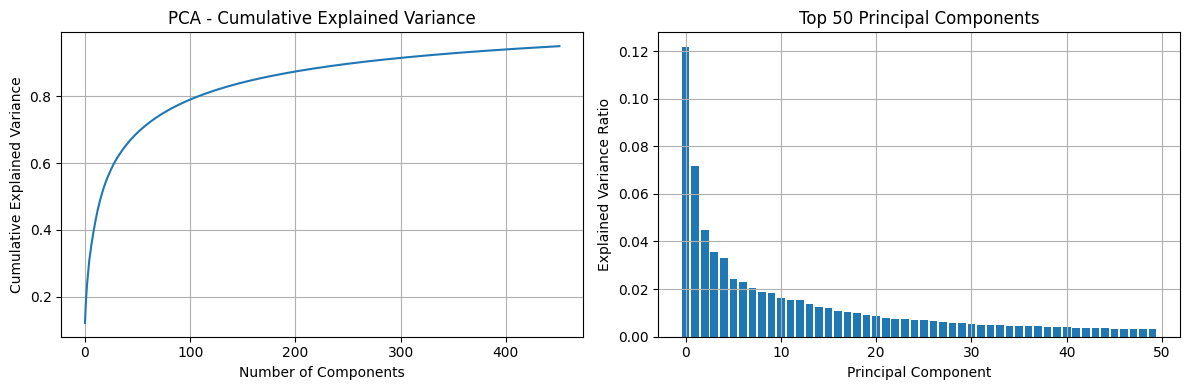


 Final Feature Dimensions 
Train: (3603, 256)
Validation: (772, 256)
Test: (773, 256)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

# 1. Analisis Variance (menghapus fitur dengan variance rendah)
from sklearn.feature_selection import VarianceThreshold

# Hapus fitur dengan variance sangat rendah (hampir konstan)
variance_selector = VarianceThreshold(threshold=0.01)
X_train_var = variance_selector.fit_transform(X_train_features)
X_val_var = variance_selector.transform(X_val_features)
X_test_var = variance_selector.transform(X_test_features)

print(" 1. Variance Threshold ")
print(f"Original features: {X_train_features.shape[1]}")
print(f"After variance filtering: {X_train_var.shape[1]}")
print(f"Removed {X_train_features.shape[1] - X_train_var.shape[1]} low-variance features\n")

# 2. PCA (Principal Component Analysis) - Dimensionality Reduction
# Pertahankan 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_var)
X_val_pca = pca.transform(X_val_var)
X_test_pca = pca.transform(X_test_var)

print(" 2. PCA (Principal Component Analysis) ")
print(f"Before PCA: {X_train_var.shape[1]} features")
print(f"After PCA: {X_train_pca.shape[1]} components")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
print(f"Dimensionality reduction: {(1 - X_train_pca.shape[1]/X_train_var.shape[1])*100:.2f}%\n")

# 3. SelectKBest dengan f_classif (ANOVA F-test)
k_best = min(256, X_train_pca.shape[1])  # Pilih top 256 fitur atau semua jika lebih sedikit
selector_anova = SelectKBest(score_func=f_classif, k=k_best)
X_train_selected = selector_anova.fit_transform(X_train_pca, y_train)
X_val_selected = selector_anova.transform(X_val_pca)
X_test_selected = selector_anova.transform(X_test_pca)

print(" 3. SelectKBest (ANOVA F-test) ")
print(f"Before selection: {X_train_pca.shape[1]} features")
print(f"After selection: {X_train_selected.shape[1]} features")
print(f"Selected top {k_best} most discriminative features\n")

# Visualisasi Feature importance dari PCA
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)

plt.subplot(1, 2, 2)
top_n = 50
plt.bar(range(top_n), pca.explained_variance_ratio_[:top_n])
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title(f'Top {top_n} Principal Components')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n Final Feature Dimensions ")
print(f"Train: {X_train_selected.shape}")
print(f"Validation: {X_val_selected.shape}")
print(f"Test: {X_test_selected.shape}")


In [ ]:
# Bandingkan performa dengan dan tanpa seleksi fitur
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

print(" Perbandingan: Sebelum vs Sesudah Feature Selection")
print("\nMenggunakan model sederhana untuk validasi...\n")

print("1. Logistic Regression")

lr_before = LogisticRegression(max_iter=1000, random_state=42)
lr_before.fit(X_train_pca, y_train)
acc_before = lr_before.score(X_val_pca, y_val)

lr_after = LogisticRegression(max_iter=1000, random_state=42)
lr_after.fit(X_train_selected, y_train)
acc_after = lr_after.score(X_val_selected, y_val)

print(f"   Before selection ({X_train_pca.shape[1]} features): {acc_before*100:.2f}%")
print(f"   After selection ({X_train_selected.shape[1]} features): {acc_after*100:.2f}%")
print(f"   Improvement: {(acc_after-acc_before)*100:.2f}%\n")

print("2. Random Forest")
rf_before = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_before.fit(X_train_pca, y_train)
acc_rf_before = rf_before.score(X_val_pca, y_val)

rf_after = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_after.fit(X_train_selected, y_train)
acc_rf_after = rf_after.score(X_val_selected, y_val)

print(f"   Before selection: {acc_rf_before*100:.2f}%")
print(f"   After selection: {acc_rf_after*100:.2f}%")
print(f"   Improvement: {(acc_rf_after-acc_rf_before)*100:.2f}%")


 Perbandingan: Sebelum vs Sesudah Feature Selection

Menggunakan model sederhana untuk validasi...

1. Logistic Regression
   Before selection (452 features): 77.07%
   After selection (256 features): 76.30%
   Improvement: -0.78%

2. Random Forest
   Before selection: 69.43%
   After selection: 71.76%
   Improvement: 2.33%


## CLASSIFICATION
Model klasifikasi menggunakan fitur yang sudah diekstrak dan diseleksi

## MLP (FEATURE EXTRACTED)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

NUM_CLASSES = len(train_images.class_indices)
input_dim = X_train_selected.shape[1]

# Hitung class weights
classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, weights))

print("=== Building MLP Classifier ===")
print(f"Input dimensions: {input_dim}")
print(f"Output classes: {NUM_CLASSES}")
print(f"\nClass weights: {class_weight_dict}\n")

# MLP model
mlp_model = Sequential([
    Dense(512, activation='relu', input_dim=input_dim),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(NUM_CLASSES, activation='softmax')
], name='MLP_Classifier')

mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

mlp_model.summary()


=== Building MLP Classifier ===
Input dimensions: 256
Output classes: 5

Class weights: {np.int64(0): np.float64(0.9544370860927153), np.int64(1): np.float64(0.9098484848484848), np.int64(2): np.float64(0.9214833759590793), np.int64(3): np.float64(1.0852409638554217), np.int64(4): np.float64(1.1813114754098362)}



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "MLP_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,037 (1.14 MB)

 Trainable params: 298,245 (1.14 MB)

 Non-trainable params: 1,792 (7.00 KB)

=== Training MLP Classifier ===
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4164 - loss: 1.7341
Epoch 1: val_loss improved from inf to 0.72857, saving model to best_mlp_classifier.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4173 - loss: 1.7311 - val_accuracy: 0.7124 - val_loss: 0.7286 - learning_rate: 0.0010
Epoch 2/50
111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6750 - loss: 0.8948
Epoch 2: val_loss improved from 0.72857 to 0.56481, saving model to best_mlp_classifier.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6752 - loss: 0.8939 - val_accuracy: 0.7889 - val_loss: 0.5648 - learning_rate: 0.0010
Epoch 3/50
111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7358 - loss: 0.6956
Epoch 3: val_loss improved from 0.56481 to 0.50878, saving model to best_mlp_classifier.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7359 - loss: 0.6955 - val_accuracy: 0.8005 - val_loss: 0.5088 - learning_rate: 0.0010
Epoch 4/

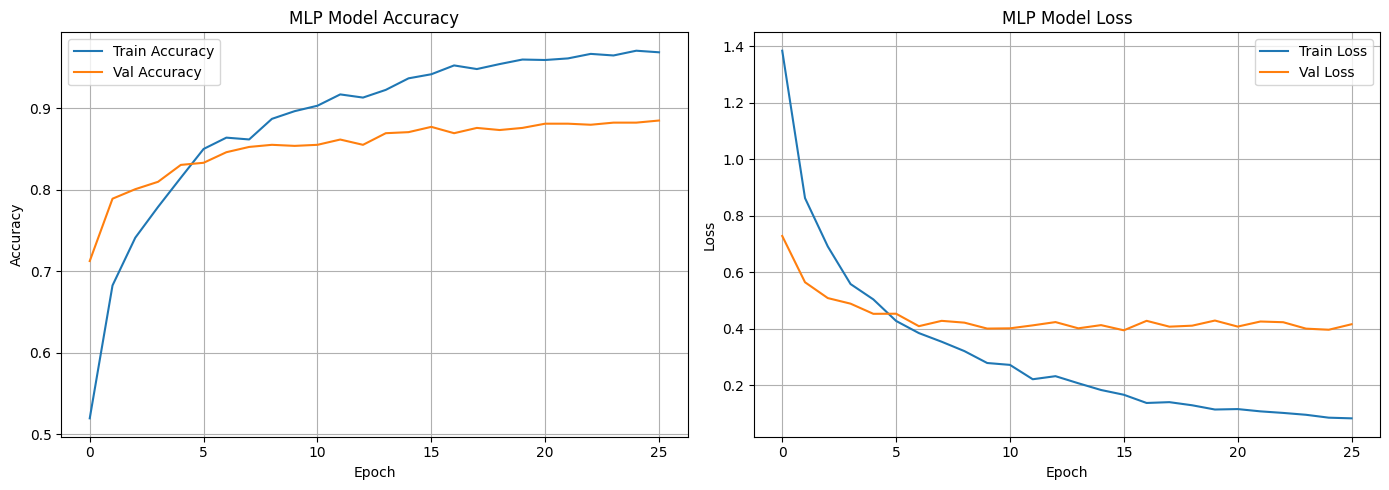

In [ ]:
# Train MLP Classifier
mlp_checkpoint = "best_mlp_classifier.keras"

mlp_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint(mlp_checkpoint, monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

print("=== Training MLP Classifier ===")
mlp_history = mlp_model.fit(
    X_train_selected, y_train,
    validation_data=(X_val_selected, y_val),
    epochs=50,
    batch_size=32,
    callbacks=mlp_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['accuracy'], label='Train Accuracy')
plt.plot(mlp_history.history['val_accuracy'], label='Val Accuracy')
plt.title('MLP Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mlp_history.history['loss'], label='Train Loss')
plt.plot(mlp_history.history['val_loss'], label='Val Loss')
plt.title('MLP Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


MLP CLASSIFIER - TEST SET EVALUATION
Test Accuracy: 89.00%
Test Loss: 0.3527

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      BROKEN     0.9583    0.8519    0.9020       162
        GOOD     0.8469    0.9765    0.9071       170
 SKIN-DAMAGE     0.8868    0.8393    0.8624       168
     SPOTTED     0.8514    0.8811    0.8660       143
    WRINKLED     0.9286    0.9000    0.9141       130

    accuracy                         0.8900       773
   macro avg     0.8944    0.8897    0.8903       773
weighted avg     0.8935    0.8900    0.8899       773



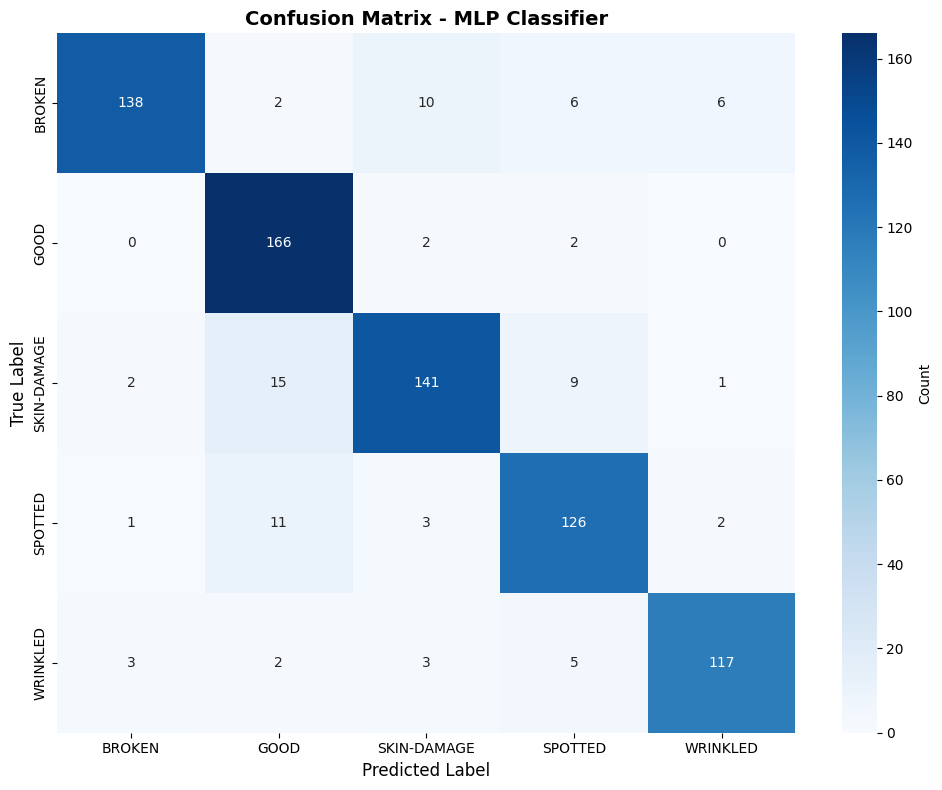

In [ ]:
# Evaluate MLP Classifier
from sklearn.metrics import classification_report, confusion_matrix

best_mlp = tf.keras.models.load_model(mlp_checkpoint)

# Predictions
y_pred_mlp = best_mlp.predict(X_test_selected, verbose=0)
y_pred_classes_mlp = np.argmax(y_pred_mlp, axis=1)

# Evaluation
test_loss_mlp, test_acc_mlp = best_mlp.evaluate(X_test_selected, y_test, verbose=0)

print("="*60)
print("MLP CLASSIFIER - TEST SET EVALUATION")
print("="*60)
print(f"Test Accuracy: {test_acc_mlp*100:.2f}%")
print(f"Test Loss: {test_loss_mlp:.4f}")

# Get class names
idx_to_class = {v: k for k, v in train_images.class_indices.items()}
class_names = [idx_to_class[i] for i in range(NUM_CLASSES)]

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_classes_mlp, target_names=class_names, digits=4))

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_classes_mlp)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - MLP Classifier', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()


## MOBILENETV2 (Transfer Learning)

In [ ]:
# MOBILENETV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

cnn_model = tf.keras.Model(inputs, outputs, name='CNN_MobileNetV2')

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

y_train = train_images.classes  # Array [0,1,2,3,4] sesuai urutan sampel
classes = np.unique(y_train)

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, weights))

print("\nClass Distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for idx, count in zip(unique, counts):
    class_name = list(train_images.class_indices.keys())[idx]
    print(f"  {class_name} (class {idx}): {count} samples")

print("\nComputed Class Weights:")
for idx, weight in class_weight_dict.items():
    class_name = list(train_images.class_indices.keys())[idx]
    print(f"  {class_name} (class {idx}): {weight:.4f}")


Class Distribution:
  BROKEN (class 0): 755 samples
  GOOD (class 1): 792 samples
  SKIN-DAMAGE (class 2): 782 samples
  SPOTTED (class 3): 664 samples
  WRINKLED (class 4): 610 samples

Computed Class Weights:
  BROKEN (class 0): 0.9544
  GOOD (class 1): 0.9098
  SKIN-DAMAGE (class 2): 0.9215
  SPOTTED (class 3): 1.0852
  WRINKLED (class 4): 1.1813


In [ ]:
checkpoint_path = "best_soybean.keras"
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, mode="min", verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
]

history = cnn_model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1826 - loss: 2.0419
Epoch 1: val_loss improved from inf to 1.44393, saving model to best_soybean.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.1830 - loss: 2.0400 - val_accuracy: 0.3795 - val_loss: 1.4439 - learning_rate: 1.0000e-04
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3684 - loss: 1.4564
Epoch 2: val_loss improved from 1.44393 to 1.19469, saving model to best_soybean.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.3688 - loss: 1.4559 - val_accuracy: 0.5363 - val_loss: 1.1947 - learning_rate: 1.0000e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4944 - loss: 1.2263
Epoch 3: val_loss improved from 1.19469 to 1.06147, saving model to best_soybean.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.4946 - loss: 1.2259 - val_accuracy: 0.5855 - val_loss: 1.0615 - learning_rate: 1.0000e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step

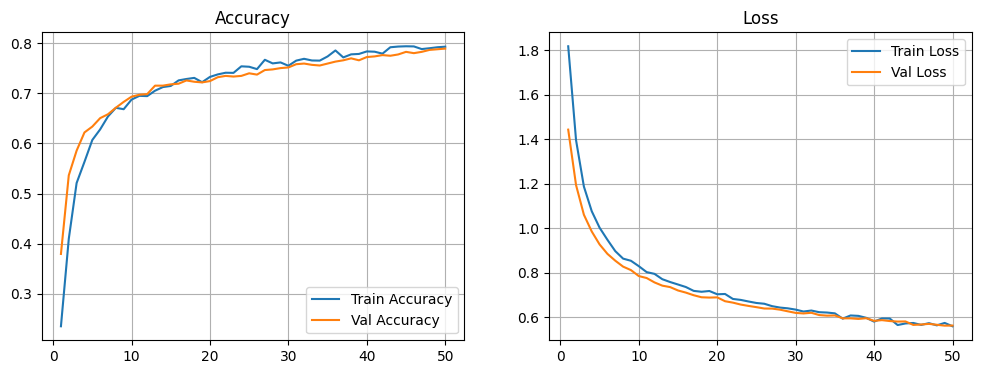

In [ ]:
acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Val Accuracy")
plt.title("Accuracy"); plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.title("Loss"); plt.grid(True); plt.legend()
plt.show()

Test Accuracy: 82.02%
Test Loss: 0.5441

 Classification Report 
              precision    recall  f1-score   support

      BROKEN       0.90      0.81      0.85       162
        GOOD       0.80      0.94      0.86       170
 SKIN-DAMAGE       0.86      0.72      0.78       168
     SPOTTED       0.69      0.78      0.73       143
    WRINKLED       0.88      0.86      0.87       130

    accuracy                           0.82       773
   macro avg       0.83      0.82      0.82       773
weighted avg       0.83      0.82      0.82       773



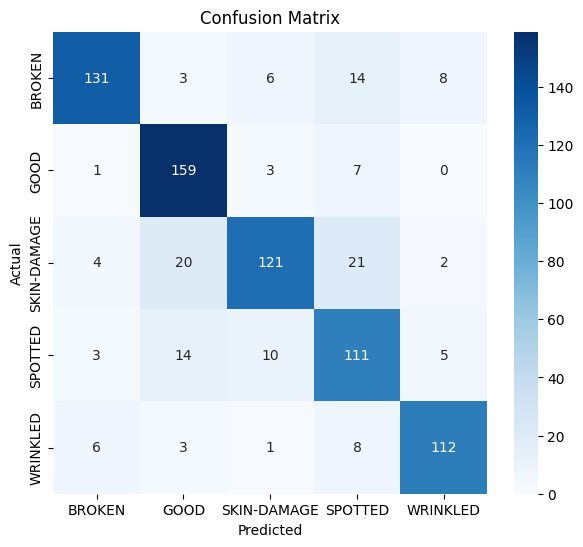

In [ ]:
# Test + Evaluation
best_model = tf.keras.models.load_model(checkpoint_path)
test_loss, test_acc = best_model.evaluate(test_images, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

pred_probs = best_model.predict(test_images, verbose=0)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_images.classes

idx_to_class = {v: k for k, v in train_images.class_indices.items()}
class_names = [idx_to_class[i] for i in range(NUM_CLASSES)]

print("\n Classification Report ")
print(classification_report(true_labels, pred_labels, target_names=class_names))

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()